In [1]:
import os
import sys
import yaml
import joblib
import pysftp
sys.path.insert(0, "D:/IIT/DDP/DDP/B-SOID/")
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from BSOID.utils import *
from BSOID.data import *
from BSOID.preprocessing import *
from BSOID.analysis import *
from scipy import ndimage

from getpass import getpass

%matplotlib notebook

D:\Applications\anaconda3\envs\ddp\lib\site-packages\behavelet\morlet.py:26: UserWarning: CuPy was not found, so GPU functionality is unavailable. See https://github.com/cupy/cupy#installation for installation instructions
  warnings.warn('CuPy was not found, so GPU functionality is unavailable. '


In [2]:
SAVE_DIR = "D:/IIT/DDP/data/paper/"
FIG1_SAVEDIR = os.path.join(SAVE_DIR, "figure1")
FIG2_SAVEDIR = os.path.join(SAVE_DIR, "figure2")

# Figure 1
---

## Keypoints on Frame

In [19]:
def likelihood_filter_no_hour_trim(data, fps, conf_threshold, bodyparts):
    N = data.shape[0]

    # retrieve confidence, x and y data from csv data
    conf, x, y = [], [], []
    for col in data.columns:
        if col.endswith('_lh'):
            conf.append(data[col])
        elif col.endswith('_x'):
            x.append(data[col])
        elif col.endswith('_y'):
            y.append(data[col])
    conf, x, y = np.array(conf).T, np.array(x).T, np.array(y).T
    conf, x, y = conf[:,bodyparts], x[:,bodyparts], y[:,bodyparts]
    
    # take average of nose and ears
    conf = np.hstack((conf[:,:3].mean(axis=1).reshape(-1,1), conf[:,3:]))
    x = np.hstack((x[:,:3].mean(axis=1).reshape(-1,1), x[:,3:]))
    y = np.hstack((y[:,:3].mean(axis=1).reshape(-1,1), y[:,3:]))

    n_dpoints = conf.shape[1]
    
    filt_x, filt_y = np.zeros_like(x), np.zeros_like(y)

    points_filtered_by_idx = np.zeros((n_dpoints,))
    for i in range(n_dpoints):    
        j, perc_filt = 0, 0

        while j < N and conf[j,i] < conf_threshold:
            perc_filt += 1
            j += 1
        
        filt_x[0:j,i] = np.repeat(x[j, i], j)
        filt_y[0:j,i] = np.repeat(x[j, i], j)
        prev_best_idx = j

        for j in range(j, N):
            if conf[j,i] < conf_threshold:
                filt_x[j,i] = x[prev_best_idx,i]
                filt_y[j,i] = y[prev_best_idx,i]
                perc_filt += 1
            else:
                filt_x[j,i], filt_y[j,i] = x[j,i], y[j,i]
                prev_best_idx = j

        points_filtered_by_idx[i] = perc_filt
    
    x, y, conf = filt_x, filt_y, conf
    perc_filt = points_filtered_by_idx.max()
    
    return {'conf': conf, 'x': x, 'y': y}, perc_filt * 100 / N

def download_video_and_keypt_data(input_csv, config_file, strain=None):
    save_dir = os.path.join(FIG1_SAVEDIR, "frame_keypoint_fig")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
    df = pd.read_csv(input_csv)
    if strain is not None:
        df = df[df["Strain"] == strain]
    
    done = False
    session = ftplib.FTP("ftp.box.com")
    password = getpass("Box login password: ")
    session.login("ae16b011@smail.iitm.ac.in", password)
    while not done:
        try:
            data = dict(df.iloc[np.random.randint(0, df.shape[0], 1)[0]])
            data_fname, vid_fname = get_video_and_keypoint_data(session, data, save_dir)
            done = True
        except Exception as e:
            session.quit()
            session = ftplib.FTP("ftp.box.com")
            password = getpass("Box login password: ")
            session.login("ae16b011@smail.iitm.ac.in", password)
    
    print(f"Extracting data from {os.path.join(save_dir, data_fname)}")
    conf, pos = process_h5py_data(h5py.File(os.path.join(save_dir, data_fname)))
    bsoid_data = bsoid_format(conf, pos)
    
    with open(config_file, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    fdata, perc_filt = likelihood_filter_no_hour_trim(bsoid_data, fps=30, conf_threshold=0.3, bodyparts=config["bodyparts"])

    shape = fdata['x'].shape
    print(f'Preprocessed {shape} data, with {round(perc_filt, 2)}% data filtered')

    with open(os.path.join(save_dir, "rawdata.pkl"), "wb") as f:
        joblib.dump(fdata, f)

def get_frames_from_video(n=10):
    save_dir = os.path.join(FIG1_SAVEDIR, "frame_keypoint_fig")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
    
    with open(os.path.join(save_dir, "rawdata.pkl"), "rb") as f:
        keypoints = joblib.load(f)
    x, y = keypoints['x'], keypoints['y']

    assert x.shape[0] == y.shape[0]
    N = x.shape[0]

    idxs = np.random.randint(0, N, n)
    idxs.sort()
    x, y = x[idxs], y[idxs]

    count, frames = 0, []
    
    video_file = [os.path.join(save_dir, f) for f in os.listdir(save_dir) if f.endswith(".avi")][0]
    video = cv2.VideoCapture(video_file)
    success, image = video.read()
    while success:
        if count in idxs:
            frames.append(image)
        count += 1

        success, image = video.read()
    
    assert count == N, f"# of frames ({count}) in video does not match with # of keypoint-datapoints ({N})"

    for i, f in enumerate(frames):
        cv2.imwrite(os.path.join(save_dir, f"frame{i}.jpg"), f)
    
    with open(os.path.join(save_dir, "keypointdata.pkl"), "wb") as f:
        joblib.dump([x, y], f)
        
def keypoint_plot(image_file, keypoint_data_file, idx, deg=0, xlim=None, ylim=None):
    save_dir = os.path.join(FIG1_SAVEDIR, "frame_keypoint_fig")
    with open(keypoint_data_file, "rb") as f:
        x, y = joblib.load(f)
    
    x, y = x[idx], y[idx]

    HEAD, BASE_NECK, CENTER_SPINE, HINDPAW1, HINDPAW2, BASE_TAIL, MID_TAIL, TIP_TAIL = np.arange(8)
    link_connections = ([BASE_TAIL, CENTER_SPINE],
                        [CENTER_SPINE, BASE_NECK],
                        [BASE_NECK, HEAD],
                        [BASE_TAIL, HINDPAW1], [BASE_TAIL, HINDPAW2],
                        [BASE_TAIL, MID_TAIL],
                        [MID_TAIL, TIP_TAIL])
    
    fig, ax = plt.subplots()
    img = ndimage.rotate(plt.imread(image_file), deg)
    ax.imshow(img, extent=[0, img.shape[0], 0, img.shape[1]])
    
    for link in link_connections:
        h, t = link
        plt.plot([x[h], x[t]], [y[h], y[t]], linewidth=2, color="y")
    
    cmap = mpl.cm.get_cmap("tab20")
    for idx in np.arange(8):
        plt.scatter(x[idx], y[idx], color=cmap(idx), s=30)
    
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()
    
    plt.savefig(os.path.join(save_dir, "keypoint_plot.jpg"), bbox_inches="tight", pad_inches=0)
    fig.show()

    fig, ax = plt.subplots()
    img = ndimage.rotate(plt.imread(image_file), deg)
    ax.imshow(img, extent=[0, img.shape[0], 0, img.shape[1]])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()
    plt.savefig(os.path.join(save_dir, "original_image.jpg"), bbox_inches="tight", pad_inches=0)

In [ ]:
# needs to be run only once
input_csv = "D:/IIT/DDP/data/paper/MergedMetaList_2019-04-18_strain-survey-mf-subset.csv"
download_video_and_keypt_data(input_csv, config_file="../config/config.yaml")

In [ ]:
# run till desirable frame is received
get_frames_from_video(n=10)

In [ ]:
# run once to generate keypoint plot
idx = 3
image_file = os.path.join(FIG1_SAVEDIR, "frame_keypoint_fig", f"frame{idx}.jpg")
keypoint_file = os.path.join(FIG1_SAVEDIR, "frame_keypoint_fig", "keypointdata.pkl")
keypoint_plot(image_file, keypoint_file, idx, deg=90, xlim=200, ylim=200)

# centroid velocity and corresponding behaviours

In [ ]:
def get_metadata_for_plot(data_dir, label_info_file, config_file):
    save_dir = os.path.join(FIG1_SAVEDIR, "centroid_velocity_fig")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
    
    with open(label_info_file, "rb") as f:
        label_info = joblib.load(f)
    strain = random.sample(list(label_info.keys()), 1)[0]
    data = random.sample(label_info[strain], 1)[0]
    metadata, labels = data["metadata"], data["labels"]
    
    del label_info
    print("getting raw data from JAX database...")
    
    pose_dir, _ = get_pose_data_dir(data_dir, metadata["NetworkFilename"])
    _, _, movie_name = metadata['NetworkFilename'].split('/')
    filename = f"{pose_dir}/{movie_name[0:-4]}_pose_est_v2.h5".replace('\\', '/')
    password = getpass("JAX ssh login password: ")
    with pysftp.Connection('login.sumner.jax.org', username='laadd', password=password) as sftp:
        sftp.get(filename)
    print(f"Extracted: {filename}")
    
    with open(config_file, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        
    filename = f"{movie_name[0:-4]}_pose_est_v2.h5"
    conf, pos = process_h5py_data(h5py.File(filename, "r"))
    data = bsoid_format(conf, pos)
    fdata, perc_filt = likelihood_filter(data, config["fps"], config["conf_threshold"], config["bodyparts"], end_trim=5, clip_window=-1)
    if perc_filt > 10:
        strain, mouse_id = metadata['Strain'], metadata['MouseID']
        print(f'mouse:{strain}/{mouse_id}: % data filtered from raw data is too high ({perc_filt} %)')
    
    if labels.size < fdata['x'].shape[0]:
        print(f"# of labels ({labels.size}) not equal to # of datapoints ({fdata['x'].shape[0]})")
        fdata['x'], fdata['y'] = fdata['x'][:labels.size], fdata['y'][:labels.size]
    
    keypoints = {'x': fdata['x'], 'y': fdata['y'], "labels": labels}
    with open(os.path.join(save_dir, "metadata.pkl"), "wb") as f:
        joblib.dump(keypoints, f)
    
    os.remove(filename)
    
def plot_centroid_velocity(fps, tspan=None):
    save_dir = os.path.join(FIG1_SAVEDIR, "centroid_velocity_fig")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
    
    with open(os.path.join(save_dir, "metadata.pkl"), "rb") as f:
        metadata = joblib.load(f)
    
    from BSOID.preprocessing import smoothen_data
    centroid_idx = 2
    x, y = metadata['x'][:,centroid_idx], metadata['y'][:,centroid_idx]
    x, y = smoothen_data(x, 3), smoothen_data(y, 3)
    x, y = (x[1:] - x[0:-1]) * 0.0264 / (1 / fps), (y[1:] - y[0:-1]) * 0.0264 / (1 / fps)
    x, y = x/100, y/100
    vel = np.sqrt(x ** 2 + y ** 2)
    
    def plot_time_series(vel, fps, final=False):
        t = np.arange(vel.shape[0])
        fig, ax = plt.subplots(figsize=(12,1.3))
        ax.plot(t, vel, color="k", linewidth=1)
        ax.set_ylim([-0.01*vel.max(), 1.1 * vel.max()])
        ax.set_xlim([0, t.max() + 1])
        if final:
            ax.set_xticks([t.max() + 1])
            ax.set_xticklabels([f"{int(t.max() / fps)} seconds"], fontsize=10)
        ax.set_yticks([0, vel.max()])
        ax.set_yticklabels(["0", f"{round(vel.max(), 2)} m/s"])
        ax.yaxis.tick_right()
        ax.tick_params(axis=u'both', which=u'both',length=0)
        for _, spine in ax.spines.items():
            spine.set_visible(False)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "centroid_velocity.jpg"), bbox_inches="tight", pad_inches=0.5)
        plt.show()
      
    if tspan is None:
        plot_time_series(vel, fps)
    else:
        plot_time_series(vel[tspan[0]:tspan[1]], fps, final=True)     

In [ ]:
data_dir = "/projects/kumar-lab/StrainSurveyPoses"
label_info_file = 'D:/IIT/DDP/data/finals/label_info.sav'
config_file = "../config/config.yaml"
# get_metadata_for_plot(data_dir, label_info_file, config_file)

tspan = [67000, 72000]
plot_centroid_velocity(30, tspan)

## ethrogram corresponding to centroid velocity plot

In [ ]:
def ethogram_plot(tspan, fps, groups, group_names):
    cmap = mpl.cm.get_cmap('tab20')

    with open(os.path.join(FIG1_SAVEDIR, "centroid_velocity_fig", "metadata.pkl"), "rb") as f:
        metadata = joblib.load(f)
    
    labels = metadata["labels"][tspan[0]:tspan[1]]
    height, N = 1, len(labels)
    
    labels = [groups[l] for l in labels]

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 3), gridspec_kw={'height_ratios': [1, 2.75]})
    i, pat = 0, []
    while i < len(labels):
        j = i + 1
        while j < len(labels) and labels[i] == labels[j]:
            j += 1
        pat.append(patches.Rectangle((i, 0), (j - i + 1), height, color=cmap(labels[i])))
        i = j
    
    [ax[0].add_patch(p) for p in pat]
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    for _, spine in ax[0].spines.items():
        spine.set_visible(False)
    ax[0].set_xlim([0, N])
    ax[0].set_ylabel("Ethogram", fontsize=10)

    height = 0.5
    k, ylocs = 0, {}
    for _, idx in group.items():
        lab = group_names[idx]
        if idx not in ylocs:
            ylocs[idx] = (k*(height + 0.1), lab)
            k += 1
    
    i, pat = 0, []
    while i < len(labels):
        j = i + 1
        while j < len(labels) and labels[i] == labels[j]:
            j += 1
        y = ylocs[labels[i]][0]
        pat.append(patches.Rectangle((i, y), (j - i + 1), height, color=cmap(labels[i])))
        i = j    

    [ax[1].add_patch(p) for p in pat]
    ax[1].set_xlim([0, N])
    ax[1].set_ylim([0 - 0.1, (k+1)*(height+0.1) - 0.1])

    for _, lab in ylocs.items():
        y = lab[0] + (height / 2)
        ax[1].plot(np.arange(N), y * np.ones((N,)), color='gray', linestyle='-', linewidth=0.77, alpha=0.1)
    ax[1].set_yticks([lab[0] + (height / 2) for _, lab in ylocs.items()])
    ax[1].set_yticklabels([lab[1] for _, lab in ylocs.items()], fontsize=9)
    ax[1].yaxis.tick_right()
    ax[1].set_ylabel("Phenotypes", fontsize=10)
    ax[1].set_xticks([N])
    ax[1].set_xticklabels([f"{int((tspan[1] - tspan[0]) / fps)} seconds"], fontsize=10)
    ax[1].tick_params(axis=u'both', which=u'both',length=0)
    for _, spine in ax[1].spines.items():
        spine.set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "ethogram_fig", "ethogram_plot.jpg"), bbox_inches="tight", pad_inches=0, dpi=600)
    plt.show()

In [ ]:
groups = None
group_names = None

ethogram_plot(tspan, 30, groups, group_names)

# Figure 2
---

## proportion usage plots

In [15]:
def behaviour_usage_plot(label_info_file, max_label, n=30, ns=250):
    save_dir = os.path.join(FIG2_SAVEDIR, "behaviour_usage_figure")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
    
    with open(label_info_file, "rb") as f:
        label_info = joblib.load(f)
    
    strain_props = proportion_usage_across_strains(label_info, max_label)
    props = []
    for strain, data in strain_props.items():
        for d in data:
            props.append(d["prop"])
    props = np.vstack(props)
    
    prop_mean = props.mean(axis=0)
    prop_stds = bootstrap_estimate(props, ns=ns, n=n)
    idx = np.argsort(-prop_mean)
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.errorbar(
        x=np.arange(prop_mean.size), 
        y=prop_mean[idx], 
        yerr=prop_stds[idx], 
        fmt="-k", 
        ecolor=(0.59, 0.59, 0.61, 0.85), 
        elinewidth=4.5, 
        capsize=4,
        linewidth=3
    )
    ax.set_xlabel('Sorted Phenotypes', fontsize=18)
    ax.set_ylabel('Proportion Usage', fontsize=18)
    ax.set_ylim([0, 1.1 * (prop_mean[idx[0]] + prop_stds[idx[0]])])
    sns.despine(trim=True)
    ax.tick_params(axis='x', labelrotation=0, labelsize=14)
    plt.savefig(os.path.join(save_dir, "behaviour_usage_plot.jpg"), dpi=300, bbox_inches='tight', pad_inches=0)
    fig.show()
    
    prop = {"Strain": []}
    for i in range(max_label):
        prop[f"prop {i}"] = []
        
    for strain, data in strain_props.items():
        for d in data:
            if "BTBR" in strain:
                strain = "$\mathregular{BTBR T^+ Itpr3^{tf}/J}$"
            prop["Strain"].append(strain)
            [prop[f"prop {i}"].append(d["prop"][i]) for i in range(max_label)]
    prop = pd.DataFrame.from_dict(prop)
    usage = prop.groupby("Strain").mean().T
    ax = sns.heatmap(usage, xticklabels=True, yticklabels=True, cbar_kws={"pad": 0.01}, cmap="hot")
    plt.gcf().set_size_inches(15.5, 4)
    ax.set_xlabel('')
    ax.set_ylabel("Phenotypes", fontsize=13)
    ax.set_yticks(range(0, max_label, 10))
    ax.tick_params(axis='x', labelsize=10)
    ax.set_yticklabels(range(0, max_label, 10))
    plt.savefig(os.path.join(save_dir, "strainwise_usage_plot.jpg"), dpi=400, bbox_inches='tight', pad_inches=0)
    plt.show() 

<IPython.core.display.Javascript object>


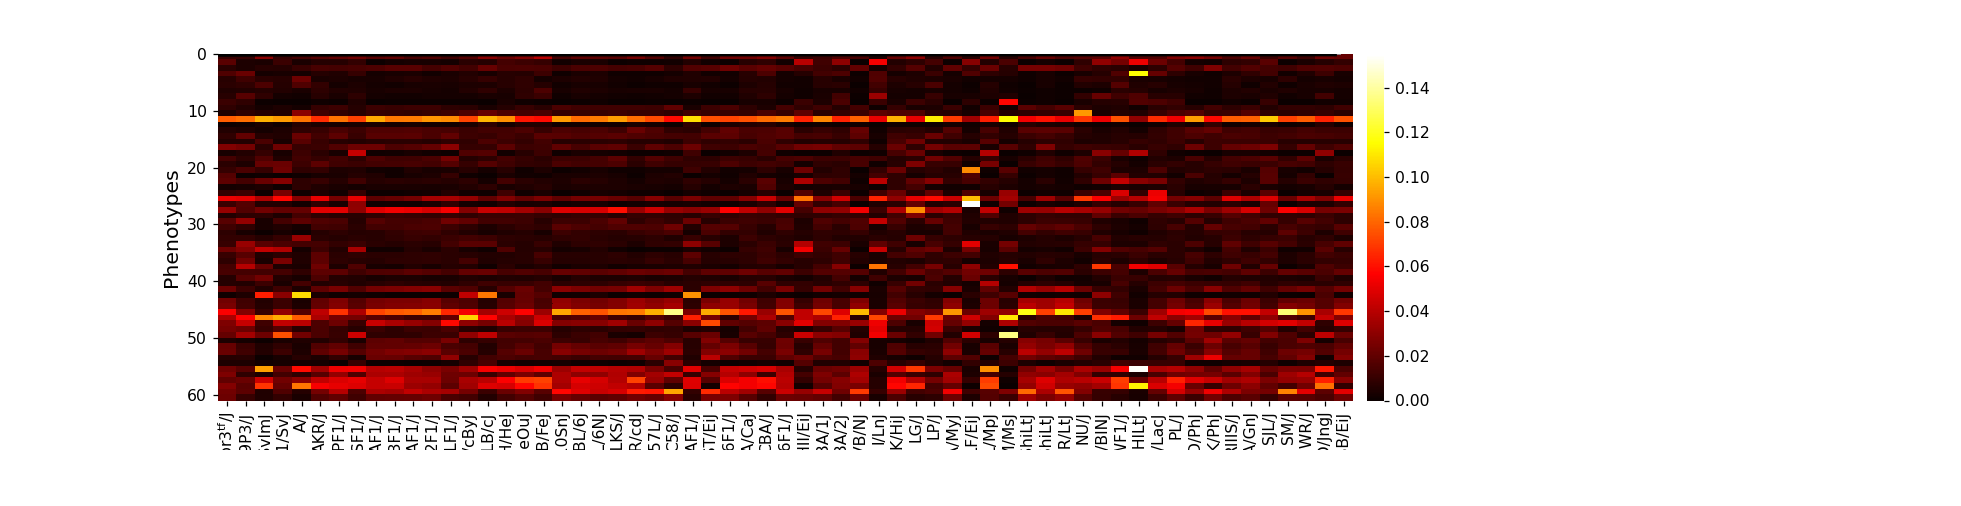

In [16]:
label_info_file = "D:/IIT/DDP/data/finals/label_info.sav"
behaviour_usage_plot(label_info_file, max_label=61, n=30, ns=250)

## vignettes

In [22]:
def download_video_file(label_info_file, config_file, strain=None):
    save_dir = os.path.join(FIG2_SAVEDIR, "vignette_figure")
    try: os.mkdir(save_dir)
    except FileExistsError: pass

    with open(label_info_file, "rb") as f:
        info = joblib.load(f)

    if strain:
        data = info[strain]
    else:
        data = info[random.sample(list(info.keys()), 1)[0]]
    data = random.sample(data, 1)[0]
    metadata, labels = data["metadata"], data["labels"]
    
    passwd = getpass("Box login password: ")
    session = ftplib.FTP("ftp.box.com")
    session.login("ae16b011@smail.iitm.ac.in", passwd)
    data_fname, vid_fname = get_video_and_keypoint_data(session, metadata, save_dir)
    data_fname, vid_fname = os.path.join(save_dir, data_fname), os.path.join(save_dir, vid_fname)
    
    conf, pos = process_h5py_data(h5py.File(os.path.join(save_dir, data_fname)))
    data = bsoid_format(conf, pos)
    with open(config_file, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    fdata, perc_filt = likelihood_filter_no_hour_trim(data, fps=config["fps"], conf_threshold=0.3, bodyparts=config["bodyparts"])

    shape = fdata['x'].shape
    print(f'Preprocessed {shape} data, with {round(perc_filt, 2)}% data filtered')
    
    os.remove(data_fname)
    data_fname = data_fname.replace(".csv", ".pkl")
    with open(data_fname, "wb") as f:
        joblib.dump(fdata, f)

    metadata["data_fname"] = data_fname
    metadata["vid_fname"] = vid_fname
    metadata["labels"] = labels

    with open(os.path.join(save_dir, "metadata.pkl"), "wb") as f:
        joblib.dump(metadata, f)
    
def save_frames_and_loc_data(behaviour_idx, min_bout_len, fps, n=10):
    save_dir = os.path.join(FIG2_SAVEDIR, "vignette_figure")
    try: os.mkdir(save_dir)
    except FileExistsError: pass
     
    min_bout_len = min_bout_len * fps // 1000
    
    with open(os.path.join(save_dir, "metadata.pkl"), "rb") as f:
        metadata = joblib.load(f)
    video_file = os.path.join(save_dir, metadata["vid_fname"])
    with open(os.path.join(save_dir, metadata["data_fname"]), "rb") as f:
        fdata = joblib.load(f)
    labels = metadata["labels"]

    save_dir = os.path.join(save_dir, f"phenotype_{behaviour_idx}_clips")
    try: os.mkdir(save_dir)
    except FileExistsError: pass

    i, locs = 0, []

    while i < len(labels):
        if labels[i] == behaviour_idx:
            j = i + 1
            while j < len(labels) and (labels[j] == labels[i]):
                j += 1
            
            if (j - i + 1) >= min_bout_len:
                locs.append([i, j, (j - i + 1)])

            i = j
        else:
            i += 1
    
    locs = sorted(locs, key=lambda x: x[-1], reverse=True)[:n]
    locs = sorted(locs, key=lambda x: x[0])

    count, i = 0, 0
    video = cv2.VideoCapture(video_file)
    success, image = video.read()
    while success and locs:
        if i == locs[0][0]:
                clip_dir = os.path.join(save_dir, f"clips_{count}")
            try: os.mkdir(clip_dir)
            except FileExistsError: pass

            k = 0
            while success and i <= locs[0][1]:
                cv2.imwrite(os.path.join(clip_dir, f"phenotype_{behaviour_idx}_frame_{k}.jpg"), image)
                success, image = video.read()
                k, i = k + 1, i + 1


            start_idx, end_idx = locs[0][:-1]
            x, y = fdata['x'][start_idx:end_idx], fdata['y'][start_idx:end_idx]

            with open(os.path.join(clip_dir, "keypoint_data.pkl"), "wb") as f:
                joblib.dump([x, y], f)
            
            del locs[0]
            count += 1
        else:
            i += 1
            success, image = video.read()

def skeletal_plot(ax, x, y, weight):
    HEAD, BASE_NECK, CENTER_SPINE, HINDPAW1, HINDPAW2, BASE_TAIL, MID_TAIL, TIP_TAIL = np.arange(8)
    link_connections = ([BASE_TAIL, CENTER_SPINE],
                        [CENTER_SPINE, BASE_NECK],
                        [BASE_NECK, HEAD],
                        [BASE_TAIL, HINDPAW1], [BASE_TAIL, HINDPAW2],
                        [BASE_TAIL, MID_TAIL],
                        [MID_TAIL, TIP_TAIL])
    
    cmap = mpl.cm.get_cmap("YlGnBu")
    for link in link_connections:
        h, t = link
        ax.plot([x[h], x[t]], [y[h], y[t]], linewidth=3, color=cmap(weight), alpha=0.5)

    for i in np.arange(8):
        ax.scatter(x[i], y[i], s=20, color=cmap(weight), alpha=0.5)
    
    return ax, cmap

def make_vignettes(behaviour_idx, clip_no, idxs, ske_idxs, weights, img_crop=None, skeletal_crop=None, deg=0):
    assert sum(weights) == 1, "weights must sum to 1"
    
    save_dir = os.path.join(FIG2_SAVEDIR, "vignette_figure")
    try os.mkdir(save_dir)
    except FileExistsError: pass
    
    frame_dir = os.path.join(save_dir, f"phenotype_{behaviour_idx}_clips", f"clips_{clip_no}")
    frames = [os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith(".jpg")]
    frames.sort(key=lambda x: int(x.split('_')[-1][:-4]))

    behaviour = frame_dir.split('/')[-3].split("_")[0]

    frames = [cv2.imread(frames[i]) for i in idxs]

    img = sum(f * w for f, w in zip(frames, weights)) / 255.0
    img = ndimage.rotate(img, deg)

    fig, ax = plt.subplots(ncols=2, gridspec_kw={"width_ratios": [1, 1]})

    ax[0].imshow(img, extent=[0, img.shape[0], 0, img.shape[1]])
    ax[1].imshow(img, extent=[0, img.shape[0], 0, img.shape[1]])

    with open(os.path.join(frame_dir, "keypoint_data.pkl"), "rb") as f:
        x, y = joblib.load(f)

    for i, idx in enumerate(ske_idxs):
        wt = (idx - min(ske_idxs))/(max(ske_idxs) - min(ske_idxs))
        ax[1], cmap = skeletal_plot(ax[1], x[idx], y[idx], wt)

    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set_ylim(ax[0].get_ylim())
    
    cax = fig.add_axes([0.57, 0.90, 0.15, 0.05])
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, orientation="horizontal", ticks=[0.0, 1.0])
    cax.set_xticks([0.0, 1.0])
    cax.set_xticklabels(["start", "end"])
    cax.tick_params(axis=u'both', which=u'both',length=0)

    for _, spine in cax.spines.items():
        spine.set_visible(False)

    for (ax_, lims) in zip(ax, [img_crop, skeletal_crop]):
        ax_.set_xlim(lims[0])
        ax_.set_ylim(lims[1])

    for ax_ in ax:
        ax_.set_xticklabels([])
        ax_.set_yticklabels([])
        ax_.set_axis_off()
        ax_. set_aspect('equal')
        ax_.set_anchor('N')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{behaviour}_fig.jpg"), dpi=400, bbox_inches="tight", pad_inches=0)
    plt.show()

In [20]:
label_info_file = "D:/IIT/DDP/data/finals/label_info.sav"
config_file = "../config/config.yaml"
download_video_file(label_info_file, config_file, strain="C57BL/6J")

Box login password: ········
Downloading: WT001G15N5F100229M-29-PSY_pose_est_v2.h5
Downloading: WT001G15N5F100229M-29-PSY.avi
Preprocessed (240036, 8) data, with 0.6% data filtered


In [23]:
save_frames_and_loc_data(behaviour_idx=24, min_bout_len=200, fps=30, n=2)